## Multi-year UNSEEN ##

Test notebook for figuring out the methodology for exploring how to create a synthetic event set for multi-year wind droughts.

In [1]:
import sys
import pathlib
import platform
venv_path = "~/nb_envs/bens-nb-env4"
py_version = platform.python_version_tuple()
sys.path.append(
    str(
        pathlib.Path(
            f"{venv_path}/lib/python{py_version[0]}.{py_version[1]}/site-packages/"
        ).expanduser()
    )
)

In [2]:
print(py_version)

('3', '11', '9')


In [3]:
# Import local modules
import sys
import os
import glob

# Import third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from xarray import DataArray

In [4]:
# Import my modules
import dictionaries as dic

sys.path.append("/home/users/benhutch/unseen_functions")
import functions as funcs

In [5]:
import pkg_resources
import sys

def print_version(package_name):
    try:
        version = pkg_resources.get_distribution(package_name).version
        print(f"{package_name}: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"{package_name}: not found")

print(f"python: {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print_version("cloudpickle")
print_version("lz4")
print_version("msgpack")
print_version("tornado")

python: 3.11.9
cloudpickle: 3.0.0
lz4: 4.3.3
msgpack: 1.0.7
tornado: 6.4


/tmp/ipykernel_10771/1774655543.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [6]:
import dask_gateway
import pathlib

In [7]:
# Create a connection to dask-gateway.
gw = dask_gateway.Gateway("https://dask-gateway.jasmin.ac.uk", auth="jupyterhub")

In [8]:
# Inspect and change the options if required before creating your cluster.
options = gw.cluster_options()
options.worker_cores = 2

In [9]:
clusters = gw.list_clusters()
if not clusters:
    cluster = gw.new_cluster(options, shutdown_on_close=False)
else:
    cluster = gw.connect(clusters[0].name)
    
cluster.adapt(minimum=1, maximum=3)

client = cluster.get_client()

2024-05-28 14:57:37,388 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [10]:
client.get_versions(check=True)

{'scheduler': {'host': {'python': '3.11.9.final.0',
   'python-bits': 64,
   'OS': 'Linux',
   'OS-release': '3.10.0-1160.114.2.el7.x86_64',
   'machine': 'x86_64',
   'processor': 'x86_64',
   'byteorder': 'little',
   'LC_ALL': 'None',
   'LANG': 'en_GB.UTF-8'},
  'packages': {'python': '3.11.9.final.0',
   'dask': '2024.5.0',
   'distributed': '2024.5.0',
   'msgpack': '1.0.7',
   'cloudpickle': '3.0.0',
   'tornado': '6.4',
   'toolz': '0.12.1',
   'numpy': '1.26.4',
   'pandas': '2.2.2',
   'lz4': '4.3.3'}},
 'workers': {},
 'client': {'host': {'python': '3.11.9.final.0',
   'python-bits': 64,
   'OS': 'Linux',
   'OS-release': '3.10.0-1160.114.2.el7.x86_64',
   'machine': 'x86_64',
   'processor': 'x86_64',
   'byteorder': 'little',
   'LC_ALL': 'None',
   'LANG': 'None'},
  'packages': {'python': '3.11.9.final.0',
   'dask': '2024.5.0',
   'distributed': '2024.5.0',
   'msgpack': '1.0.7',
   'cloudpickle': '3.0.0',
   'tornado': '6.4',
   'toolz': '0.12.1',
   'numpy': '1.26.4',

In [11]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://dask-gateway.jasmin.ac.uk/clusters/a7ed00b718564782896bc721b13912d6/status,


In [12]:
# ds = xr.tutorial.open_dataset('air_temperature', chunks={'lat': 25, 'lon': 25, 'time': -1})
# ds

In [13]:
# da = ds['air']
# da

In [14]:
# %%time

# da.resample(time='1w').mean('time').std('time').load().plot(figsize=(12, 8))

In [15]:
# import subprocess

# def downgrade_packages(env_dict):
#     scheduler_packages = env_dict['scheduler']['packages']
#     client_packages = env_dict['client']['packages']

#     for package, version in scheduler_packages.items():
#         if package != 'python' and package in client_packages and client_packages[package] != version:
#             print(f"Downgrading {package} to version {version}")
#             subprocess.run(["pip", "install", "--upgrade", f"{package}=={version}"], check=True)

# downgrade_packages(env_dict)

In [16]:
# import dask_gateway
# # Create a connection to dask-gateway.
# gw = dask_gateway.Gateway("https://dask-gateway.jasmin.ac.uk", auth="jupyterhub")
# # Inspect and change the options if required before creating your cluster.
# options = gw.cluster_options()
# options.worker_cores = 2
# options.worker_setup = "source /home/users/benhutch/bens-dask-env/bin/activate"
# # Create a dask cluster, or, if one already exists, connect to it.
# # This stage creates the scheduler job in SLURM, so may take some time.
# # While your job queues.
# clusters = gw.list_clusters()

# # create a new cluster
# cluster = gw.new_cluster(options, shutdown_on_close=False)

# # if not clusters:
# # else:
# #     cluster = gw.connect(clusters[0].name)

# # Create at least one worker, and allow your cluster to scale to three.
# cluster.adapt(minimum=1, maximum=3)

# # Get a dask client.
# client = cluster.get_client()

# # Check the versions
# client.get_versions(check=True)

### Exploring gridboxes ###

Checking that the gridboxes are where we expect them to be

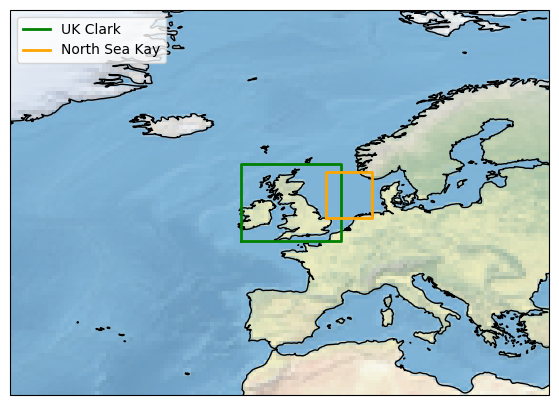

In [17]:
# First, we want to visualise th gridboxes which we might want to use
# The UK grid box or the north sea grid box

# Set up the projection
projection = ccrs.PlateCarree(central_longitude=0)

# Plot the differences between the two gridboxes
# Set up the figure
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=projection)

# # Include the stock image and coastlines
ax.stock_img()
ax.coastlines()

# Extract the lat and lon data for the UK box
lon1_uk, lon2_uk = dic.uk_grid['lon1'], dic.uk_grid['lon2']
lat1_uk, lat2_uk = dic.uk_grid['lat1'], dic.uk_grid['lat2']

# Extract the lat and lon data for the North Sea box
lon1_ns, lon2_ns = dic.north_sea_kay['lon1'], dic.north_sea_kay['lon2']
lat1_ns, lat2_ns = dic.north_sea_kay['lat1'], dic.north_sea_kay['lat2']

# Plot these boxes
ax.plot([lon1_uk, lon2_uk, lon2_uk, lon1_uk, lon1_uk],
        [lat1_uk, lat1_uk, lat2_uk, lat2_uk, lat1_uk],
        color='green', linewidth=2, transform=projection, label="UK Clark")

# Plot these boxes
ax.plot([lon1_ns, lon2_ns, lon2_ns, lon1_ns, lon1_ns],
        [lat1_ns, lat1_ns, lat2_ns, lat2_ns, lat1_ns],
        color='orange', linewidth=2, transform=projection, label="North Sea Kay")

# Zoom in on the region
ax.set_extent([-40, 30, 30, 80], crs=projection)

# Create a legend
ax.legend(loc = 'upper left')

# show the plot
plt.show()

### Choosing time windows ###

We need to define the time period over which we are looking for wind droughts. Here are three we might consider:

* 1 year (12 months Dec-Nov)
* 3 years (36 months Dec-Nov)
* 5 years (60 months Dec-Nov)

In this first example of 1 year, for 1960 there will be 11 total 12 month time series (DJFMAMJJASON):

* 1 will be the truth (from ERA5) - the weather which actually occurred.
* 10 will be from the decadal prediction system (in this case DePreSys with 10 ensemble members).
    * Here we are assuming November initialisation.

### Extracting the data ###

Model data in this example from HadGEM3-GC31-MM.

Obs data in this example from ERA5.

In [18]:
# # Set up the parameters for extraction
model_var = "sfcWind"
obs_var = "si10"
test_model = "HadGEM3-GC31-MM"
experiment = "dcppA-hindcast"

# test extracting data for daily frequency
frequency="Amon"

In [19]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import *

In [20]:
# %%time

# # Test the new function
# member_ds = funcs.load_model_data_xarray(model_variable=model_var,
#                                     model=test_model,
#                                     experiment=experiment,
#                                     start_year=1961,
#                                     end_year=2014,
#                                     grid=dic.uk_grid,
#                                     first_fcst_year=1962,
#                                     last_fcst_year=1963,
#                                     months=[10, 11, 12, 1, 2, 3],
#                                     frequency=frequency,
#                                     parallel=False,
#                                     )

In [21]:
single_file = "/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r1i1p1f2/day/tas/gn/files/d20200417/tas_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_19601101-19601230.nc"

# load single file
ds_single = xr.open_dataset(single_file)

In [ ]:
ds_single

In [24]:
%%time

# Test loading obs data
# File = surface_wind_ERA5.nc
# Directory = /home/users/benhutch/ERA5
obs_df = funcs.load_regrid_obs(
    model_ds=ds_single,
    obs_variable=obs_var,
    obs_path="/home/users/benhutch/ERA5/surface_wind_ERA5.nc",
    start_year=1961,
    end_year=2014,
    months=[10, 11, 12, 1, 2, 3],
    grid=dic.uk_grid,
)

Coordinates of the regridded obs: Coordinates:
  * time     (time) datetime64[ns] 5kB 1961-01-01 1961-02-01 ... 2014-12-01
    lon      (x) float64 3kB -179.6 -178.8 -177.9 -177.1 ... 177.9 178.7 179.6
    lat      (y) float64 3kB -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
Crosses the year boundary
Not aggregating the worst months


/opt/jaspy/lib/python3.11/site-packages/xarray/core/groupby.py:668: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 12.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


KilledWorker: Attempted to run task ('open_dataset-getitem-582a25b7b9c73921b3ebbe9ff49ba400', 0, 0, 0, 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tls://172.17.11.136:43141. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [ ]:
obs_df.head()

In [ ]:
# rename value to sfcWind_UK_obs
obs_df.rename(columns={"value": "sfcWind_UK_obs"}, inplace=True)

In [ ]:
obs_df.head()

In [ ]:
# # When you are done and whish to release your cluster:
# cluster.shutdown()

In [ ]:
%%time

# Regrid the dataset
rg_ds = funcs.regrid_ds(
    ds=member_ds,
    variable="sfcWind",
)

In [ ]:
# print(rg_ds["lon"].min().values)
# print(rg_ds["lon"].max().values)
# print(rg_ds["lat"].min().values)
# print(rg_ds["lat"].max().values)

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

import functions as funcs

In [ ]:
%%time

# Select the UK grid
uk_ds = funcs.select_gridbox(
    ds=rg_ds,
    grid=dic.uk_grid,
)

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

import functions as funcs

In [ ]:
print(uk_ds)

In [ ]:
# test the new function
dates = funcs.select_months(
    ds=uk_ds,
    months=[10, 11, 12, 1, 2, 3],
    first_day="1961-11-01",
    first_time="12:00:00",
    frequency=frequency,
)

In [ ]:
dates

In [ ]:
# first month (1) = 1961-11-16 00:00:00
# first day (1) = 1961-11-01 12:00:00
# frequency = "day"
# time_axis_type : Datetime360Day
ds = funcs.lead_time_avg(
    ds=uk_ds,
    months=[10, 11, 12, 1, 2, 3],
    first_month="1961-11-16"
)

In [ ]:
ds

In [ ]:
%%time

# set up the fname and directory
fname="test-uk-wind2.csv"
directory="/home/users/benhutch/unseen_multi_year"

# Set up the fpath
fpath=os.path.join(directory,fname)

# # Set a name
# ds.name = "sfcWind_UK"

# # save as a csv
# ds.to_dataframe().to_csv(fpath)

In [ ]:
df = pd.read_csv(fpath)

In [ ]:
df.head()

In [ ]:
# drop height from the dataframe
df = df.drop('height', axis=1)

In [ ]:
df.head()

In [ ]:
# limit df to member r1i1p1f2 and init 1961
df_subset = df[(df['member'] == 'r1i1p1f2') & (df['init'] == 1970)]

In [ ]:
df_subset

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

import functions as funcs

In [ ]:
# # Plot a histogram for all of the model data
# plt.hist(df['sfcWind_UK'], bins=50, alpha=0.5, label='model')

In [ ]:
# # plot the obs data
# plt.hist(obs_df['sfcWind_UK_obs'], bins=50, alpha=0.5, label='obs')

In [ ]:
# # Test the function for plotting the GEV distribution
# rvs = funcs.plot_gev_return_values(
#     obs_df=obs_df,
#     model_df=df,
#     obs_val_name="sfcWind_UK_obs",
#     model_val_name="sfcWind_UK",
#     ylabel="Wind Speed (m/s)",
# )

In [ ]:
# Test the function for plotting events
funcs.plot_events_ts(
    obs_df=obs_df,
    model_df=df,
    obs_val_name="sfcWind_UK_obs",
    model_val_name="sfcWind_UK",
    ylabel="10m wind speed (m/s)",
    delta_shift_bias=True, # apply a delta shift to the mean
    figsize=(12, 6),
)

In [ ]:
# # Plot the events using boxplots
# funcs.plot_events_ts_bp(
#     obs_df=obs_df,
#     model_df=df,
#     obs_val_name="sfcWind_UK_obs",
#     model_val_name="sfcWind_UK",
#     ylabel="10m wind speed (m/s)",
#     delta_shift_bias=True, # apply a delta shift to the mean
#     figsize=(12, 6),
# )

In [ ]:
# Plot the fidelity
funcs.plot_fidelity(
    obs_df=obs_df,
    model_df=df,
    obs_val_name="sfcWind_UK_obs",
    model_val_name="sfcWind_UK",
    nboot=10000,
)

In [ ]:
# Test the independence function
corr_matrix = funcs.independence_test(
    ensemble=df,
    members=df['member'].unique(),
    n_leads=len(df['lead'].unique()),
    var_name="sfcWind_UK",
    detrend=True,
)

In [ ]:
(df['lead'].unique())

In [ ]:
# Why is the first one all NaN's and zeros?
first_lead_corr_m = corr_matrix[-1]

In [ ]:
first_lead_corr_m.shape

In [ ]:
second_lead_corr_m = corr_matrix[1]

In [ ]:
second_lead_corr_m

In [ ]:
# flatten the data
flat_second_lead = second_lead_corr_m.flatten()

# plot the histogram
plt.hist(flat_second_lead, bins=10)

# Show the plot
plt.show()

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

import functions as funcs

In [ ]:
corr_matrix[0]

In [ ]:
%%time

# Plot the boxplots
funcs.plot_independence(
    corr_matrix=corr_matrix,
)

In [ ]:
%%time

# Plot the density distribution
funcs.stability_density(
    ensemble=df,
    var_name="sfcWind_UK",
    label="ONDJFM UK 10m wind speed (m/s)",
    cmap="Greys",
)

In [ ]:
df

In [ ]:
%%time

# test the model stability boot function
df_quantiles = funcs.model_stability_boot(
    ensemble=df,
    var_name="sfcWind_UK",
    label="ONDJFM UK 10m wind speed (m/s)",
    nboot=10000,
    cmap="Greys",
)

In [ ]:
df_quantiles.head()

In [ ]:
df_corr = funcs.plot_independence_sb(
    corr_matrix=corr_matrix,
)

In [ ]:
funcs.plot_independence_violin(
    corr_matrix=corr_matrix,
)

In [ ]:
funcs.plot_independence_pd(
    corr_matrix=corr_matrix,
)

In [ ]:
# Test the spatial smoothing function 
lat_res = (ds['lat'].max() - ds['lat'].min())/(ds['lat'].count()-1.)

# Calculate the resolution of the data - lon
lon_res = (ds['lon'].max() - ds['lon'].min())/(ds['lon'].count()-1.)

In [ ]:
lat_res = lat_res.values
lon_res = lon_res.values

In [ ]:
print(lat_res)
print(lon_res)

In [ ]:
import xesmf as xe

# Set up the output grid
ds_out = xe.util.grid_2d(-180.0, 180.0, lon_res, -90.0, 90.0, lat_res)

In [ ]:
# set up the regridder
regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=True)

In [ ]:
# Apply this to sfcWind
ds

In [ ]:
sfcWind_regrid = regridder(ds['sfcWind'])

In [ ]:
sfcWind_regrid

In [ ]:
ds['sfcWind'].isel(init=0, member=0, lead=0).plot()

In [ ]:
sfcWind_regrid.isel(init=0, member=0, lead=0).plot()

In [ ]:
sfcWind_regrid

In [ ]:
# test selecting the UK grid
grid = dic.uk_grid

lon1, lon2, lat1, lat2 = grid['lon1'], grid['lon2'], grid['lat1'], grid['lat2']

In [ ]:
# sfcWind_regrid = sfcWind_regrid.sel(lat=slice(lat1, lat2),
#             lon=slice(lon1, lon2)).mean(dim=('lat','lon'))

sfcWind_regrid["lat"]

In [ ]:
mask = (sfcWind_regrid['lat'] > lat1) & (sfcWind_regrid['lat'] < lat2) & (sfcWind_regrid['lon'] > lon1) & (sfcWind_regrid['lon'] < lon2)
ds_masked = sfcWind_regrid.where(mask)
mean_ds = ds_masked.mean(dim=('y','x'))

In [ ]:
ds_masked.isel(init=0, member=0, lead=0).plot()

In [ ]:
mean_ds

In [ ]:
d_lon_lat_kws_hadgem =  {'lat': lat_res, 'lon': lon_res}

In [ ]:
# regrid_ds = climpred.smoothing.spatial_smoothing_xesmf(
#     ds, 
#     d_lon_lat_kws={'lat': 5, 'lon': 5}, 
#     method='bilinear', 
#     periodic=False, 
#     filename=None, 
#     reuse_weights=False, 
#     tsmooth_kws=None, 
#     how=None
# )

In [ ]:
regrid_ds

In [ ]:
import matplotlib.pyplot as plt

# Select the data for the first init member and lead
data = ds.isel(init=0, member=0, lead=0)


In [ ]:
data

In [ ]:
data["sfcWind"].plot()

In [ ]:
# Look at the data
len(member_files[0])

In [ ]:
flat_list = [item for sublist in member_files for item in sublist]

In [ ]:
flat_list[0]

In [ ]:
print((variant_labels))

In [ ]:
# test_file = "/work/scratch-nopw2/benhutch/sfcWind/HadGEM3-GC31-MM/global/all_forecast_years/ONDJFM/outputs/all-years-ONDJFM-global-sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_196011-197103.nc"

# ds = xr.open_dataset(test_file)

In [ ]:
ds

In [ ]:
# Print the values
print(model_data.sfcWind.values)

In [ ]:
# test the read_data function
model_data = load_model_data(model_variable=model_var,
                            model=test_model,
                            experiment=experiment,
                            start_year=1961,
                            end_year=2014,
                            avg_period=2,
                            grid=dic.uk_grid)

In [ ]:
print(model_data.shape)

In [ ]:
# Take the mean of the model data over the months axis
model_data_year = model_data.mean(axis=2)

# # Print the new shape
print(model_data_year.shape)

# Winter 1 data
winter1_data = model_data[:, :, 0:4].mean(axis=2)

# summer data
summer_data = model_data[:, :, 4:10].mean(axis=2)

# winter 2 data
winter2_data = model_data[:, :, 10:].mean(axis=2)

# Print the shapes of the new data
print(winter1_data.shape)

# Print the shapes of the new data
print(summer_data.shape)

# Print the shapes of the new data
print(winter2_data.shape)

In [ ]:
# Get the data including the months, no mean
winter1_data_months = model_data[:, :, 0:4]
summer_data_months = model_data[:, :, 4:10]
winter2_data_months = model_data[:, :, 10:]
year_data_months = model_data

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import load_model_data, model_stats_bs

In [ ]:
# test the bootstrapping function
stats_dict_year = model_stats_bs(model=year_data_months.mean(axis=2),
                            nboot=10000)

In [ ]:
# test the bootstrapping function
stats_dict_winter1 = model_stats_bs(model=winter1_data_months.mean(axis=2),
                            nboot=10000)

In [ ]:
# test the bootstrapping function
stats_dict_summer = model_stats_bs(model=summer_data_months.mean(axis=2),
                            nboot=10000)

In [ ]:
# test the bootstrapping function
stats_dict_winter2 = model_stats_bs(model=winter2_data_months.mean(axis=2),
                            nboot=10000)

In [ ]:
# print(stats_dict)

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import load_model_data, load_obs_data, calculate_obs_stats

In [ ]:
obs_data = load_obs_data(obs_variable=obs_var,
                         regrid_obs_path="/home/users/benhutch/ERA5/surface_wind_ERA5_regrid_HadGEM.nc",
                        start_year=1961,
                        end_year=2014,
                        avg_period=2,
                        grid=dic.uk_grid)

In [ ]:
# Extract and print the obs years
obs_years = obs_data[1]

# print the shape of the obs data
print(obs_years.shape)
print(obs_years)

In [ ]:
# Extract the obs data for the different seasons
obs_data_year = obs_data[0]
obs_data_winter1 = obs_data[0][:, 0:4]
obs_data_summer = obs_data[0][:, 4:10]
obs_data_winter2 = obs_data[0][:, 10:]

In [ ]:
# Calculate the stats
obs_stats_year = calculate_obs_stats(obs_data=obs_data_year,
                                start_year=1960,
                                end_year=2018,
                                avg_period=1,
                                grid=dic.uk_grid)

obs_stats_winter1 = calculate_obs_stats(obs_data=obs_data_winter1,
                                start_year=1960,
                                end_year=2018,
                                avg_period=1,
                                grid=dic.uk_grid)

obs_stats_summer = calculate_obs_stats(obs_data=obs_data_summer,
                                start_year=1960,
                                end_year=2018,
                                avg_period=1,
                                grid=dic.uk_grid)

obs_stats_winter2 = calculate_obs_stats(obs_data=obs_data_winter2,
                                start_year=1960,
                                end_year=2018,
                                avg_period=1,
                                grid=dic.uk_grid)

In [ ]:
print(obs_stats_year)

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import load_model_data, load_obs_data, calculate_obs_stats, \
    plot_moments 

In [ ]:
# # Plot the moments of the distribution
# plot_moments(model_stats=stats_dict,
#              obs_stats=obs_stats,)

In [ ]:
# Plot the moments of the distribution for the different seasons
plot_moments(model_stats=stats_dict_year,
             obs_stats=obs_stats_year)

In [ ]:
# Plot the moments of the distribution for the different seasons
plot_moments(model_stats=stats_dict_winter1,
             obs_stats=obs_stats_winter1)

In [ ]:
# Plot the moments of the distribution for the summer
plot_moments(model_stats=stats_dict_summer,
             obs_stats=obs_stats_summer)

In [ ]:
# Plot the moments of the distribution for winter2
plot_moments(model_stats=stats_dict_winter2,
             obs_stats=obs_stats_winter2)

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import load_model_data, load_obs_data, calculate_obs_stats, \
    plot_moments, plot_distribution

In [ ]:
plot_distribution(model_data=model_data_year,
                  obs_data=obs_data_year,)

In [ ]:
# Plot the distribution of the winter 1 data
plot_distribution(model_data=winter1_data,
                  obs_data=obs_data_winter1,)

In [ ]:
# Plot the distribution of the summer data
plot_distribution(model_data=summer_data,
                  obs_data=obs_data_summer,)

In [ ]:
# PLot the distribution of the winter 2 data
plot_distribution(model_data=winter2_data,
                  obs_data=obs_data_winter2,)

In [ ]:
# # Take the average over the time period
# # i.e. the 2th axis
# model_data_ann_mean = model_data.mean(axis=2)

# print(model_data_ann_mean)

# print(model_data_ann_mean.shape)

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import *

In [ ]:
# Plot the year events
plot_events(model_data=model_data_year,
            obs_data=obs_data_year,
            obs_stats=obs_stats_year,
            start_year=1960,
            end_year=2018,
            figsize_y=5,)

In [ ]:
# Plot the winter 1 events
plot_events(model_data=winter1_data,
            obs_data=obs_data_winter1,
            obs_stats=obs_stats_winter1,
            start_year=1960,
            end_year=2018,
            figsize_y=5,)

In [ ]:
# Plot the summer events
plot_events(model_data=summer_data,
            obs_data=obs_data_summer,
            obs_stats=obs_stats_summer,
            start_year=1960,
            end_year=2018,
            figsize_y=5,)

In [ ]:
# Plot the winter2 events
plot_events(model_data=winter2_data,
            obs_data=obs_data_winter2,
            obs_stats=obs_stats_winter2,
            start_year=1960,
            end_year=2018,
            figsize_y=5,)

In [ ]:
# Calculate the bias
# the difference in the means between the model and the observations
bias = np.mean(model_data_ann_mean.flatten()) - obs_stats['mean']

print(bias)

# Remove the bias from the model data
model_data_ann_mean_bias = model_data_ann_mean - bias

In [ ]:
# create an array of years
years = np.arange(1960, 2019)

# Set up a figure
fig = plt.figure(figsize=(10, 5))

print("Plotting model data shape: ", model_data_ann_mean_bias.shape)

# Plot the data
# Plot the data
for i in range(min(model_data_ann_mean_bias.shape[1], model_data_ann_mean_bias.shape[0] - 1)):
    print("Plotting model data for ensemble member: ", i)
    
    # Separate data into two groups based on the condition
    below_20th = model_data_ann_mean_bias[:, i] < obs_stats['min_20']
    above_20th = ~below_20th
    
    # Plot points below the 20th percentile with a label
    plt.scatter(years[below_20th], model_data_ann_mean_bias[below_20th, i],
                color='blue', alpha=0.8, label='model wind drought' if i == 0 else None)
    
    # Plot points above the 20th percentile without a label
    plt.scatter(years[above_20th], model_data_ann_mean_bias[above_20th, i],
                color='grey', alpha=0.8, label='HadGEM3-GC31-MM' if i == 0 else None)

# plot the obs
plt.scatter(years, obs_data.mean(axis=1), label='ERA5', color='black')

# Plot the 20th percentile
# as a horizontal line
plt.axhline(y=obs_stats['min_20'],
            color='black', linestyle='-')

# Plot the min
# as a horizontal line
plt.axhline(y=obs_stats['min'],
            color='black', linestyle='--')

# Add a legend
plt.legend(loc='upper left')

# Add axis labels
plt.xlabel("Year")

# Add a title
plt.title("Annual mean " + model_var)

# Show the plot
plt.show()

In [ ]:
import seaborn as sns

# Assemble the data into a continuous array
model_data_ann_mean_flat = model_data_ann_mean.flatten()

# Plot the distribution of the data
sns.distplot(model_data_ann_mean_flat, label="model")

# # Plot the mean as a vertical line
# plt.axvline(x=model_data_ann_mean_flat.mean(),
#             color='black', linestyle='-')

# Plot the distribution of the observations
sns.distplot(obs_data.mean(axis=1), label="obs")

# # Plot the mean as a vertical line
# plt.axvline(x=obs_stats['mean'],
#             color='black', linestyle='--')

# Include a textbox with the sample size
plt.text(0.05, 0.85,f"model_n = {model_data_ann_mean_flat.shape[0]}\nobs_n = {obs_data.shape[0]}",
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Add a legend
plt.legend()

# Add a title
plt.title("Annual mean " + model_var + " distribution")

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import load_model_data, load_obs_data, calculate_obs_stats, plot_events

In [ ]:
# load model data but for 3 year averages
model_data_3yr_mean = load_model_data(model_variable=model_var,
                            model=test_model,
                            experiment=experiment,
                            start_year=1960,
                            end_year=2018,
                            avg_period=1,
                            grid=dic.uk_grid)

In [ ]:
# Load the observations
obs_data_3yr_mean = load_obs_data(obs_variable=obs_var,
                         regrid_obs_path="/home/users/benhutch/ERA5/surface_wind_ERA5_regrid_HadGEM.nc",
                        start_year=1960,
                        end_year=2018,
                        avg_period=1,
                        grid=dic.uk_grid)

In [ ]:
# Calculate the stats
obs_stats_3yr_mean = calculate_obs_stats(obs_data=obs_data_3yr_mean[0],
                                start_year=1960,
                                end_year=2018,
                                avg_period=1,
                                grid=dic.uk_grid)

In [ ]:
# Calculate the stats dict for the model data
stats_dict_3yr_mean = model_stats_bs(model=model_data_3yr_mean.mean(axis=2),
                            nboot=10000)

In [ ]:
# plot the moments of the distribution
plot_moments(model_stats=stats_dict_3yr_mean,
             obs_stats=obs_stats_3yr_mean,)

In [ ]:
# Plot the distribution of the data
plot_distribution(model_data=model_data_3yr_mean.mean(axis=2),
                  obs_data=obs_data_3yr_mean[0],)

In [ ]:
import importlib

importlib.reload(sys.modules['functions'])

from functions import load_model_data, load_obs_data, calculate_obs_stats, plot_events

In [ ]:
plot_events(model_data=model_data_3yr_mean,
            obs_data=obs_data_3yr_mean,
            obs_stats=obs_stats_3yr_mean,
            start_year=1960,
            end_year=2018,
            figsize_y=5)

In [ ]:
# load model data but for 5 year averages
model_data_5yr_mean = load_model_data(model_variable=model_var,
                            model=test_model,
                            experiment=experiment,
                            start_year=1960,
                            end_year=2018,
                            avg_period=5,
                            grid=dic.uk_grid)

In [ ]:
obs_data_5yr_mean = load_obs_data(obs_variable=obs_var,
                            regrid_obs_path="/home/users/benhutch/ERA5/surface_wind_ERA5_regrid_HadGEM.nc",
                            start_year=1960,
                            end_year=2018,
                            avg_period=5,
                            grid=dic.uk_grid)

In [ ]:
# Calculate the stats
obs_stats_5yr_mean = calculate_obs_stats(obs_data=obs_data_5yr_mean[0],
                                start_year=1960,
                                end_year=2018,
                                avg_period=5,
                                grid=dic.uk_grid)

In [ ]:
# Calculate the model stats bs
stats_dict_5yr_mean = model_stats_bs(model=model_data_5yr_mean.mean(axis=2),
                            nboot=10000)

In [ ]:
# Plot the moments of the distribution
plot_moments(model_stats=stats_dict_5yr_mean,
             obs_stats=obs_stats_5yr_mean,)

In [ ]:
# Plot the distribution of the data
plot_distribution(model_data=model_data_5yr_mean.mean(axis=2),
                  obs_data=obs_data_5yr_mean[0],)

In [ ]:
# Plot the events
plot_events(model_data=model_data_5yr_mean,
            obs_data=obs_data_5yr_mean,
            obs_stats=obs_stats_5yr_mean,
            start_year=1960,
            end_year=2018,
            figsize_y=5)

In [ ]:
# Load the observations data as an iris cube for the si10 variable
# Deal with the expver variables
obs = xr.open_mfdataset(dic.obs_path, combine='by_coords', parallel=True)[obs_var]

# Combine the two expver variables
obs = obs.sel(expver=1).combine_first(obs.sel(expver=5))

# Convert to an iris cube
obs = obs.to_iris()

print(obs)

In [ ]:
# Finding paths for the model variables
# Set up a dataframe with 4 columns
# one for the variable, one for the experiment, one for the model and one for the path
df = pd.DataFrame(columns=['variable', 'experiment', 'model', 'path'])

# # Print the dataframe
# print(df)

# Populate the dataframe
# For variable 'sfcwind', set the 'experiment' column to 'dcppA-hindcast'
# Set the 'model' column to 'HadGEM3-GC31-MM'
# Set the 'path' column to the path for the sfcwind variable
df.loc[0] = [model_var, experiment, test_model, os.path.join(dic.gws_base, experiment, "data",
                          model_var, test_model, "merged_files")]

# Form the EC-Earth3 path
ec_path = os.path.join(dic.gws_base, experiment, "data", model_var, "EC-Earth3", "merged_files")

# print the path
print(ec_path)
# # If the model is EC-Earth3, 
df.loc[1] = [model_var, experiment, "EC-Earth3", ec_path]

# models
models = ["FGOALS-f3-L", "IPSL-CM6A-LR", "MIROC6", "MPI-ESM1-2-HR", "CanESM5"]

# Loop through the models
for model in models:
    # Form the path
    path = os.path.join(dic.gws_base, experiment, model_var, model,
                        "data")
    
    # Assert that the path exists
    assert os.path.exists(path), f"{path} does not exist"

    # Assert that there are non-empty files in the path
    assert len(os.listdir(path)) > 0, f"{path} is empty"

    # Add the path to the dataframe
    df.loc[len(df)] = [model_var, experiment, model, path]


In [ ]:
# dataframe
df

In [ ]:
# Make a new folder in the PWD
os.mkdir("paths")

# Extract the current time
now = pd.Timestamp.now().strftime("%Y%m%dT%H%M%S")

# Save the dataframe as a csv
df.to_csv("paths/paths_{}.csv".format(now))

In [ ]:
# open multiple files as a single dataset for a year
start_year = 1961

# Form the directory containing the data
hadgem_dir = os.path.join(dic.gws_base, experiment, "data",
                          model_var, test_model, "merged_files")

# List the files in the directory
files = glob.glob(os.path.join(hadgem_dir, "*.nc"))

# Find all of the files for the start year
files = [f for f in files if str(start_year) in f]

# Print the files
print(files)

# Print the length of the files
print(len(files))

import re

# Extract the member from the file names
members = [re.search('s\d+-r\d+i\d+p\d+f\d+', f).group(0) for f in files]

# Group the files by member
file_groups = {member: [f for f, m in zip(files, members) if m == member] for member in set(members)}

from tqdm import tqdm

# # Open multiple files and combine by members
# datasets = {member: xr.open_mfdataset(file_group, combine='by_coords', parallel=True)[model_var] for member, file_group in tqdm(file_groups.items())}

# Open each file and extract the 'variant_label' attribute
variant_labels = [xr.open_dataset(file).attrs['variant_label'] for file in files]

print(variant_labels)

# Create the files as a nested list of lists
paths_test = [[f] for f in files]

# Now you can use variant_labels in your concat_dim argument
datasets = xr.open_mfdataset(paths_test,
                             concat_dim=variant_labels,
                                combine='nested',
                             parallel=True,
                             chunks={'time': 1000})


In [ ]:
datasets

In [ ]:
# Load one example of the model data as an iris cube
init_year = 1960
realisation = 1

# Form the directory containing the data
hadgem_dir = os.path.join(dic.gws_base, experiment, "data",
                          model_var, test_model, "merged_files")

# List the files in the directory
files = glob.glob(os.path.join(hadgem_dir, "*.nc"))

# Print the files
print(files)

# Find the file constaining fs{init_year}r{realisation}
file = [f for f in files if f"s{init_year}" in f and f"r{realisation}i" in f][0]

# Print rthe file
print(file)

# Load the file as an iris cube
hadgem_example = iris.load_cube(file, model_var)

# Print the cube
print(hadgem_example)

In [ ]:
import iris.quickplot as qplt

# Quick plot of the data
# Set up the figure
fig = plt.figure(figsize=(10, 5))
qplt.contourf(hadgem_example[0,:,:], 25)
plt.gca().coastlines()


In [ ]:
# Same but for the observations
# Set up the figure
projection = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=projection)
qplt.contourf(obs[0,:,:], 25)

In [ ]:
# Importlib reload
import importlib

# Reload the dictionaries
importlib.reload(dic)

In [ ]:
print(dic.obs_path)

In [ ]:
# Import cdo
from cdo import *
cdo = Cdo()

# Give up on Iris regridding, just use cdo in python instead
target_grid = file # This is the example HadGEM file
input_obs = dic.obs_path # for surface wind
output_obs = "/home/users/benhutch/ERA5/surface_wind_ERA5_regrid_HadGEM.nc"

# Regrid the ERA5 data to the HadGEM grid
cdo.remapbil(target_grid, input=input_obs, output=output_obs)

In [ ]:
# Importlib reload
import importlib

# Reload the dictionaries
importlib.reload(dic)

In [ ]:
# Load the regridded observations data as an iris cube for the si10 variable
# Deal with the expver variables
obs_regrid = xr.open_mfdataset(dic.regrid_hadgem_obs_path, combine='by_coords', parallel=True)[obs_var]

# Combine the two expver variables
obs_regrid = obs_regrid.sel(expver=1).combine_first(obs_regrid.sel(expver=5))

# Convert to an iris cube
obs_regrid = obs_regrid.to_iris()

# Print the cube
print(obs_regrid)

In [ ]:
# Side by side comparison of the two
# Set up the figure
projection = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=(10, 5))

# Plot the HadGEM data
ax = fig.add_subplot(1, 2, 1, projection=projection)
qplt.contourf(hadgem_example[0,:,:], 25)
ax.set_title("HadGEM3-GC31-MM")

# Plot the ERA5 data
ax = fig.add_subplot(1, 2, 2, projection=projection)
qplt.contourf(obs_regrid[0,:,:], 25)
ax.set_title("ERA5")

Regridding complete (for HadGEM at least), now to process the data.

### Time series ###

Now we want to collapse both of these into time series (although they won't run for the same time) for our selected gridbox.

In [ ]:
# print the types of the two cubes
print(type(hadgem_example))
print(type(obs_regrid))

# Convert these back to xarray datasets
hadgem_example = DataArray.from_iris(hadgem_example)

# Print the cube
print(hadgem_example)

# Convert these back to xarray datasets
obs_regrid = DataArray.from_iris(obs_regrid)

# Print the cube
print(obs_regrid)

In [ ]:
from datetime import datetime as dt

# Import timedelta
from datetime import timedelta


# Take the mean for the gridbox for the HadGEM data
hadgem_example_uk_ts = hadgem_example.sel(lat=slice(lat1_uk, lat2_uk),
                                          lon=slice(lon1_uk, lon2_uk)).mean(dim=('lat', 'lon'))

# # Print the cube
# print(hadgem_example_uk_ts)

# Take the mean for the gridbox for the ERA5 data
obs_regrid_uk_ts = obs_regrid.sel(lat=slice(lat1_uk, lat2_uk),
                                  lon=slice(lon1_uk, lon2_uk)).mean(dim=('lat', 'lon'))

# # Print the cube
# print(obs_regrid_uk_ts)

# Limit the datasets to the same time period
# 5-year time period
hadgem_example_uk_ts = hadgem_example_uk_ts.sel(time=slice("1960-12-01", "1965-11-30"))

# Limit the observations to the same time period
obs_regrid_uk_ts = obs_regrid_uk_ts.sel(time=slice("1960-12-01", "1965-11-30"))

# Create a datetime object for the time
initial_time = dt.strptime("1960-12-15", '%Y-%m-%d')

# final time
final_time = dt.strptime("1965-11-15", '%Y-%m-%d')

# Create a datetime object from the initial time and final time
# in monthly increments
time = [initial_time + timedelta(days=x) for x in range(0, (final_time - initial_time).days, 30)]

# print the time
print(time)

# Print the length of the time
print(len(time))

# Extract the values
hadgem_values = hadgem_example_uk_ts.values

# Extract the values
obs_values = obs_regrid_uk_ts.values

# Process a 12-month running mean
hadgem_values_12m_rm = pd.Series(hadgem_values).rolling(window=12).mean().values

# Process a 12-month running mean
obs_values_12m_rm = pd.Series(obs_values).rolling(window=12).mean().values

# Process a 36-month running mean
hadgem_values_36m_rm = pd.Series(hadgem_values).rolling(window=36).mean().values

# Process a 36-month running mean
obs_values_36m_rm = pd.Series(obs_values).rolling(window=36).mean().values


# Plot the two time series
# Set up the figure
# Convert the time values to datetime objects

# set up the figure
fig = plt.figure(figsize=(10, 5))

# Plot the HadGEM data
ax = fig.add_subplot(1, 1, 1)

# # Plot the HadGEM data
ax.plot(time, hadgem_values, label="HadGEM3-GC31-MM", color='red')

# Plot the 12-month running mean
ax.plot(time, hadgem_values_12m_rm, label="HadGEM3 1yr-RM", color='red', linestyle='--')

# Plot the 36-month running mean
ax.plot(time, hadgem_values_36m_rm, label="HadGEM3 3yr-RM", color='red', linestyle=':')

# Plot the ERA5 data
ax.plot(time, obs_values, label="ERA5", color='k')

# Plot the 12-month running mean
ax.plot(time, obs_values_12m_rm, label="ERA5 1yr-RM", color='k', linestyle='--')

# Plot the 36-month running mean
ax.plot(time, obs_values_36m_rm, label="ERA5 3yr-RM", color='k', linestyle=':')

# Add a legend
ax.legend()

# Add a title
ax.set_title("UK Wind Speed")

# Include a y-label
ax.set_ylabel("Wind Speed (m/s)")

# # show the plot
plt.show()
